In [1]:
# # !pip install -q -U jax jaxlib
# # !pip install -q pandas
# !pip install -q ipywidgets
# !pip install -q -U flax
# !pip install -q sentence-transformers
# #!pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q transformers
# !pip install -q torch torchvision

In [8]:
import os 
# import sys
import json
import natsort

import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from transformers import CLIPVisionModel
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
from transformers import AutoTokenizer  # Or BertTokenizer
from torch.utils.data import Dataset,DataLoader




from IPython.display import display, Image

from PIL import Image as PilImage

os.environ['TOKENIZERS_PARALLELISM'] = "false"

# import transformers
# from transformers import AutoTokenizer

# import torch
# import torchvision
from torchvision import transforms
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode
from tqdm.notebook import tqdm

# !wget -q -N https://github.com/huggingface/transformers/raw/master/examples/research_projects/jax-projects/hybrid_clip/modeling_hybrid_clip.py
# !wget -q -N https://github.com/huggingface/transformers/raw/master/examples/research_projects/jax-projects/hybrid_clip/configuration_hybrid_clip.py

# sys.path.append('.')

# from modeling_hybrid_clip import FlaxHybridCLIP

In [3]:
f = open('../../../datasets/pracegover/pracegover_173k/pracegover_captions_val2014.json')
dataset_valid = json.load(f)
f.close()

valid_annotations = []
for data in dataset_valid['annotations']:
    d = {
        'image_id' : data['image_id'],  # some formula for obtaining values
        'comment' : data['caption'].replace('\n'," "),
    }
    valid_annotations.append(d)

valid_annotations = pd.DataFrame(valid_annotations)

def get_path_image(image_id):
    image_id = int(image_id)
    return f"../../../datasets/pracegover/images/i-{image_id:08d}.jpg"

In [4]:
valid_annotations

,image_id,comment
0,391760,versos em fotografia de um pássaro com os pés ...
1,208391,poema em página de livro § time-lapse § a flor...
2,382172,versos sobre fotografia de um pássaro pousado ...
3,382501,versos sobre fotografia de pegadas sobre a nev...
4,191147,poema em página de livro § tocata e fuga § que...
...,...,...
69329,173414,"Sobre foto de Moro estão as escritas ""SEGURO! ..."
69330,173417,"Sobre foto de Santos Cruz estão as escritas ""Ú..."
69331,173423,Sobre foto de agência da Caixa estão as escrit...
69332,181315,Sobre foto de briga em estádio estão as escrit...


In [5]:
valid_annotations

,image_id,comment
0,391760,versos em fotografia de um pássaro com os pés ...
1,208391,poema em página de livro § time-lapse § a flor...
2,382172,versos sobre fotografia de um pássaro pousado ...
3,382501,versos sobre fotografia de pegadas sobre a nev...
4,191147,poema em página de livro § tocata e fuga § que...
...,...,...
69329,173414,"Sobre foto de Moro estão as escritas ""SEGURO! ..."
69330,173417,"Sobre foto de Santos Cruz estão as escritas ""Ú..."
69331,173423,Sobre foto de agência da Caixa estão as escrit...
69332,181315,Sobre foto de briga em estádio estão as escrit...


In [6]:
class CLIPTBR(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.projection_dim = 512
        self.model_clip = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.model_bertimbau = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased').to(device)
        self.model_clip.gradient_checkpointing_enable()
        self.model_bertimbau.gradient_checkpointing_enable()
        self.visual_projection = nn.Linear(self.model_clip.vision_model.post_layernorm.normalized_shape[0], self.projection_dim, bias=False).to(device)
        self.text_projection = nn.Linear(self.model_bertimbau.pooler.dense.in_features, self.projection_dim, bias=False).to(device)

        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07)).to(device)

    def encode_visual(self, visual_inputs):
        outputs = self.model_clip(visual_inputs.to(device))
        hidden_states = outputs.pooler_output

        return self.visual_projection(hidden_states)

    def encode_text(self, text_inputs):
        outputs = self.model_bertimbau(**text_inputs.to(device))
        return self.text_projection(outputs.pooler_output)

    def forward(self, data):
        image_input, text_input = data
        image_features = self.encode_visual(image_input['pixel_values'])
        text_features = self.encode_text(text_input)
        
        return image_features, text_features

    def compute_logits(self, image_features, text_features,fixed_logit):
        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        if (fixed_logit) >= 0:
            logit_scale = self.logit_scale.exp()
        else:
            logit_scale = 20
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape: [batch_size, batch_size]
        return logits_per_image, logits_per_text
    
    
    def model_requires_grad(self, status = True):
        for param in self.model_clip.parameters():
            param.requires_grad = status
        for param in self.model_bertimbau.parameters():
            param.requires_grad = status

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
model = CLIPTBR()

model= nn.DataParallel(model)
model.load_state_dict(torch.load('clip_ptbr_weights'))
model.eval()
model.to(device)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.5.mlp.fc1.bias', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.11.self_attn.out_proj.weight', 'text_model.encoder.layers.10.self_attn.out_proj.bias', 'text_model.encoder.layers.5.layer_norm1.bias', 'text_model.encoder.layers.7.self_attn.v_proj.weight', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'text_model.encoder.layers.5.self_attn.q_proj.weight', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.encoder.layers.10.self_attn.q_proj.bias', 'text_model.encoder.layers.10.mlp.fc2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.final_layer_norm.bias', 'text_model.encoder.layers.3.layer_norm1.weight', 'text_model.encoder.layers.1.self_attn.q_proj.weight', 'text_model.encoder.layers.5.layer_norm2.weight', 'text_mode

DataParallel(
  (module): CLIPTBR(
    (model_clip): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
          (position_embedding): Embedding(50, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0): CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): CLIPMLP(
                (ac

In [9]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

def tokenize(texts):
    inputs = tokenizer(texts, max_length=96, padding="max_length", truncation='longest_first', return_tensors="pt")
    # return inputs['input_ids'], inputs['attention_mask']
    return inputs

language_model = lambda queries: np.asarray(model.module.encode_text(tokenize(queries)).detach().cpu())

image_model = lambda images: np.asarray(model.module.encode_visual(images).detach().cpu())

# Utils

In [10]:
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, main_dir, transform, value_image_list):
        self.main_dir = main_dir
        self.transform = transform
        # all_imgs = os.listdir(main_dir)
        all_imgs = [f"i-{i:08d}.jpg" for i in value_image_list]
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def get_image_name(self, idx):
        return self.total_imgs[idx]

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = PilImage.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

class SimpleTextDataset(torch.utils.data.Dataset):

    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]


def text_encoder(text):
    # inputs = tokenizer([text], max_length=96, truncation=True, padding="max_length", return_tensors="np")
    # embedding = model.get_text_features(inputs['input_ids'], inputs['attention_mask'])[0]
    embedding = language_model(text)
    embedding = embedding / np.linalg.norm(embedding)
    return embedding

def precompute_text_features(loader):
    text_features = []

    for i, (texts) in enumerate(tqdm(loader)):
        # inputs = tokenizer(texts, max_length=96, truncation=True, padding="max_length", return_tensors="np")
        # embedding = model.get_text_features(inputs['input_ids'], inputs['attention_mask'])
        # embedding /= jnp.linalg.norm(embedding, axis=1, keepdims=True)
        embedding = language_model(texts)
        embedding = embedding / np.linalg.norm(embedding)

        text_features.extend(embedding)

    return np.array(text_features)

def precompute_image_features(loader):
    image_features = []
    for i, (images) in enumerate(tqdm(loader)):
        # images = images.permute(0, 2, 3, 1).numpy()
        # features = model.get_image_features(images,)
        features =image_model(images.to(device))
        features = features / np.linalg.norm(features, axis=1, keepdims=True)
        image_features.extend(features)
    return np.array(image_features)

def find_image(text_query, datatset, image_features, n=1):
    zeroshot_weights = text_encoder(text_query)
    zeroshot_weights = zeroshot_weights / np.linalg.norm(zeroshot_weights)
    distances = np.dot(image_features, zeroshot_weights.reshape(-1, 1))
    file_paths = []
    for i in range(1, n+1):
        idx = np.argsort(distances, axis=0)[-i, 0]
        file_paths.append('../../../datasets/pracegover/images/' + dataset.get_image_name(idx))
    return file_paths

def show_images(image_list):
    for im_path in image_list:
        display(Image(filename=im_path))

In [11]:
image_size = 224

val_preprocess = transforms.Compose([
    Resize([image_size], interpolation=InterpolationMode.BICUBIC),
    CenterCrop(image_size),
    ToTensor(),
    # Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [12]:
dataset = CustomDataSet("../../../datasets/pracegover/images/", transform=val_preprocess, value_image_list = valid_annotations['image_id'])
loader = DataLoader(dataset=dataset, batch_size=128, shuffle=False, drop_last=False)

In [13]:
text_dataset = SimpleTextDataset(valid_annotations['comment'])
text_loader = DataLoader(dataset=text_dataset, batch_size=24, shuffle=False)

### Compute the features

In [14]:
image_features = precompute_image_features(loader)

  0%|          | 0/542 [00:00<?, ?it/s]

In [15]:
text_features = precompute_text_features(text_loader)

  0%|          | 0/2889 [00:00<?, ?it/s]

In [16]:
def compute_mrr(data, dataset, n):
    collect_rr = []

    pbar = tqdm(total=len(data), position=0, leave=True)

    found = np.matmul(text_features, image_features.T)
    for index, distances in enumerate(found):
        pbar.update(1)
        image_path = get_path_image(data[index]["image_id"])
        collect_rr.append(new_rr(distances, image_path, dataset, n))

    pbar.close()
    return np.average(collect_rr)


def new_rr(distances, target_image, dataset, n):
    image_paths = []
    idxs = distances.argsort()[-n:][::-1]
    for idx in idxs:
        image_paths.append('../../../datasets/pracegover/images/' + dataset.get_image_name(idx))

    if target_image in image_paths:
        return 1/(image_paths.index(target_image) + 1)
    else:
        return 0

    return 1/rank

def internal_hits(distances, target_image, dataset, n):
    image_paths = []
    idxs = distances.argsort()[-n:][::-1]
    for idx in idxs:
        image_paths.append('../../../datasets/pracegover/images/' + dataset.get_image_name(idx))

    if target_image in image_paths:
        return 1
    else:
        return 0

def compute_hits(data, dataset, n):
    collect_rr = []

    pbar = tqdm(total=len(data), position=0, leave=True)

    found = np.matmul(text_features, image_features.T)
    for index, distances in enumerate(found):
        pbar.update(1)
        image_path = get_path_image(data[index]["image_id"])
        collect_rr.append(internal_hits(distances, image_path, dataset, n))

    pbar.close()
    return np.average(collect_rr)

In [17]:
data

{'image_id': 184091,
 'id': 184091,
 'caption': 'Sobre foto de Bolsonaro estão as escritas "JUSTO! Bolsonaro quer ‘punição severa’ para militar com 39 kg de cocaína".'}

In [18]:
print('MRR@1:', compute_mrr(dataset_valid['annotations'], dataset, 1))
print('MRR@5:', compute_mrr(dataset_valid['annotations'], dataset, 5))
print('MRR@10:', compute_mrr(dataset_valid['annotations'], dataset, 10))


  0%|          | 0/69334 [00:00<?, ?it/s]

MRR@1: 0.24032941990942394


  0%|          | 0/69334 [00:00<?, ?it/s]

MRR@5: 0.3100705762444591


  0%|          | 0/69334 [00:00<?, ?it/s]

MRR@10: 0.32040021593198964


In [ ]:
# Italian CLIP
# HBox(children=(FloatProgress(value=0.0, max=8486.0), HTML(value='')))
# MRR@1: 0.3796841857176526
# HBox(children=(FloatProgress(value=0.0, max=8486.0), HTML(value='')))
# MRR@5: 0.5039358944143294
# HBox(children=(FloatProgress(value=0.0, max=8486.0), HTML(value='')))
# MRR@10: 0.5204435690530435

In [19]:
compute_hits(dataset_valid['annotations'], dataset, 100)

  0%|          | 0/69334 [00:00<?, ?it/s]

0.732281420370958

In [ ]:
#Italian CLIP
#0.9913975960405373

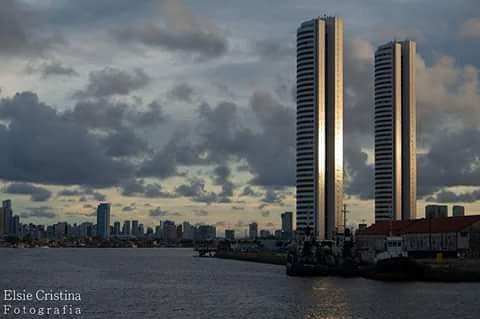

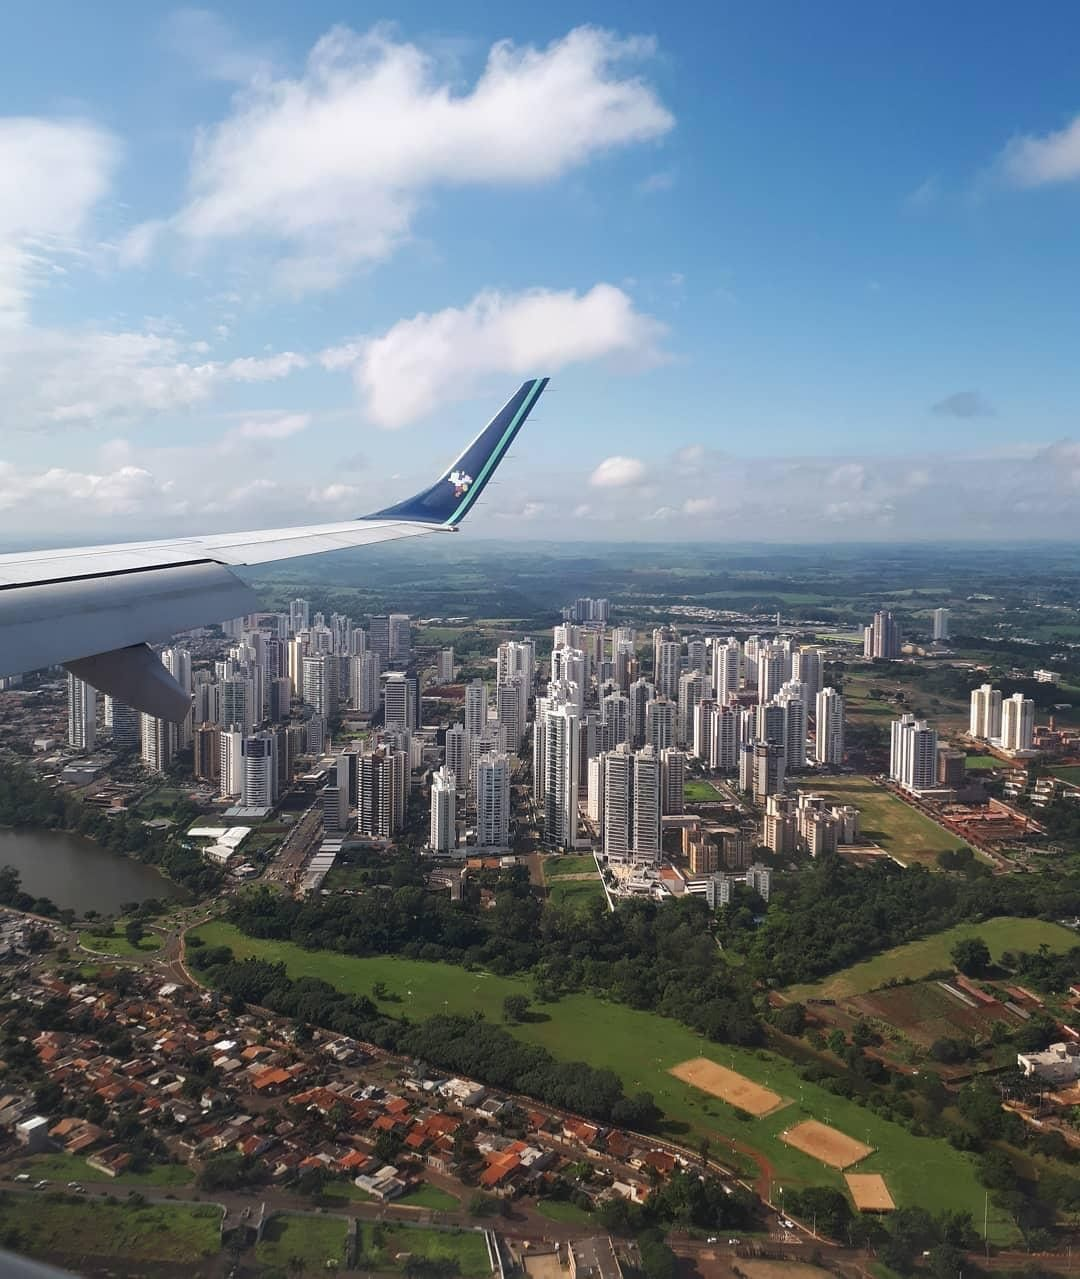

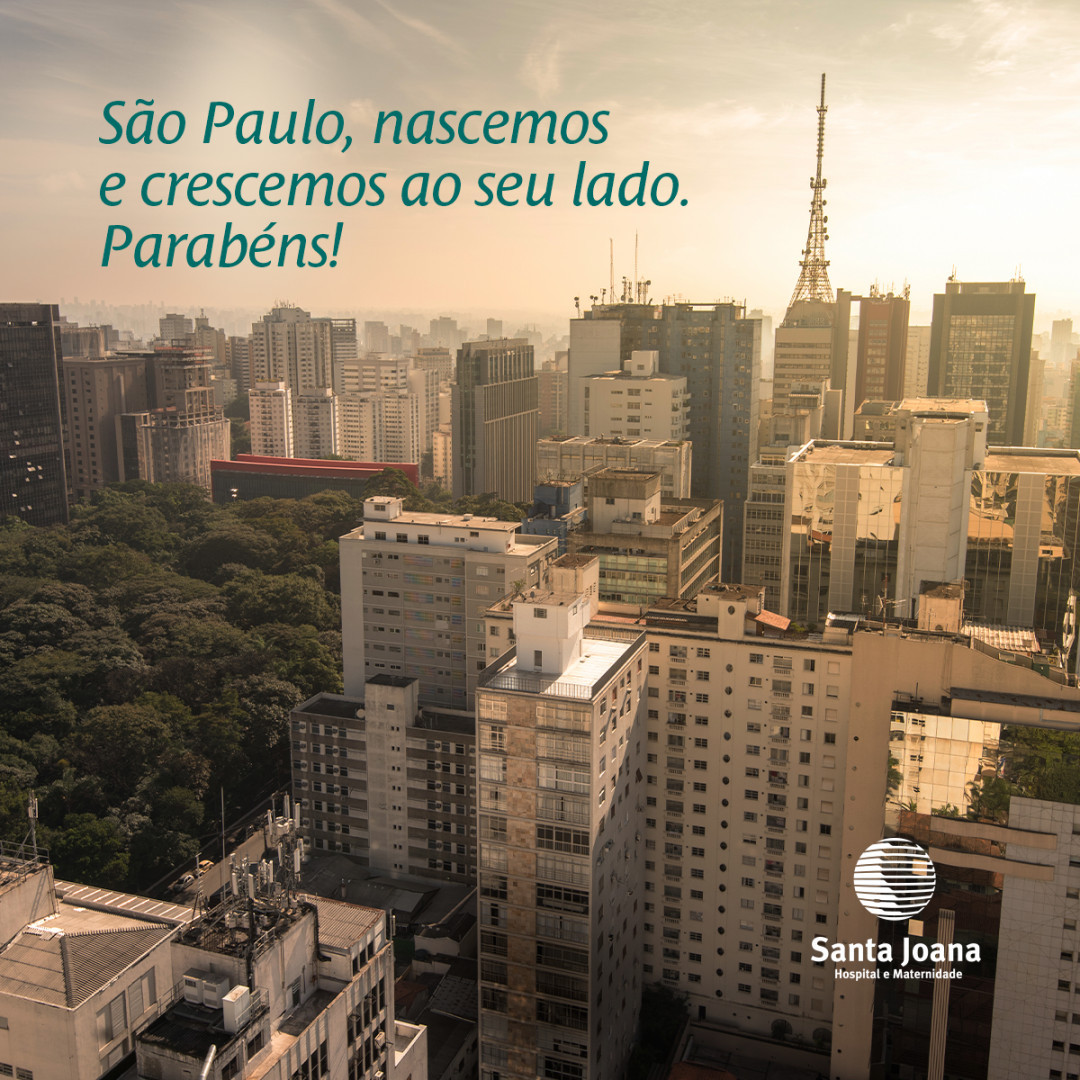

In [25]:
text = "Cidade de São Paulo"

image_paths = find_image(text, dataset, image_features, n=3)
show_images(image_paths)

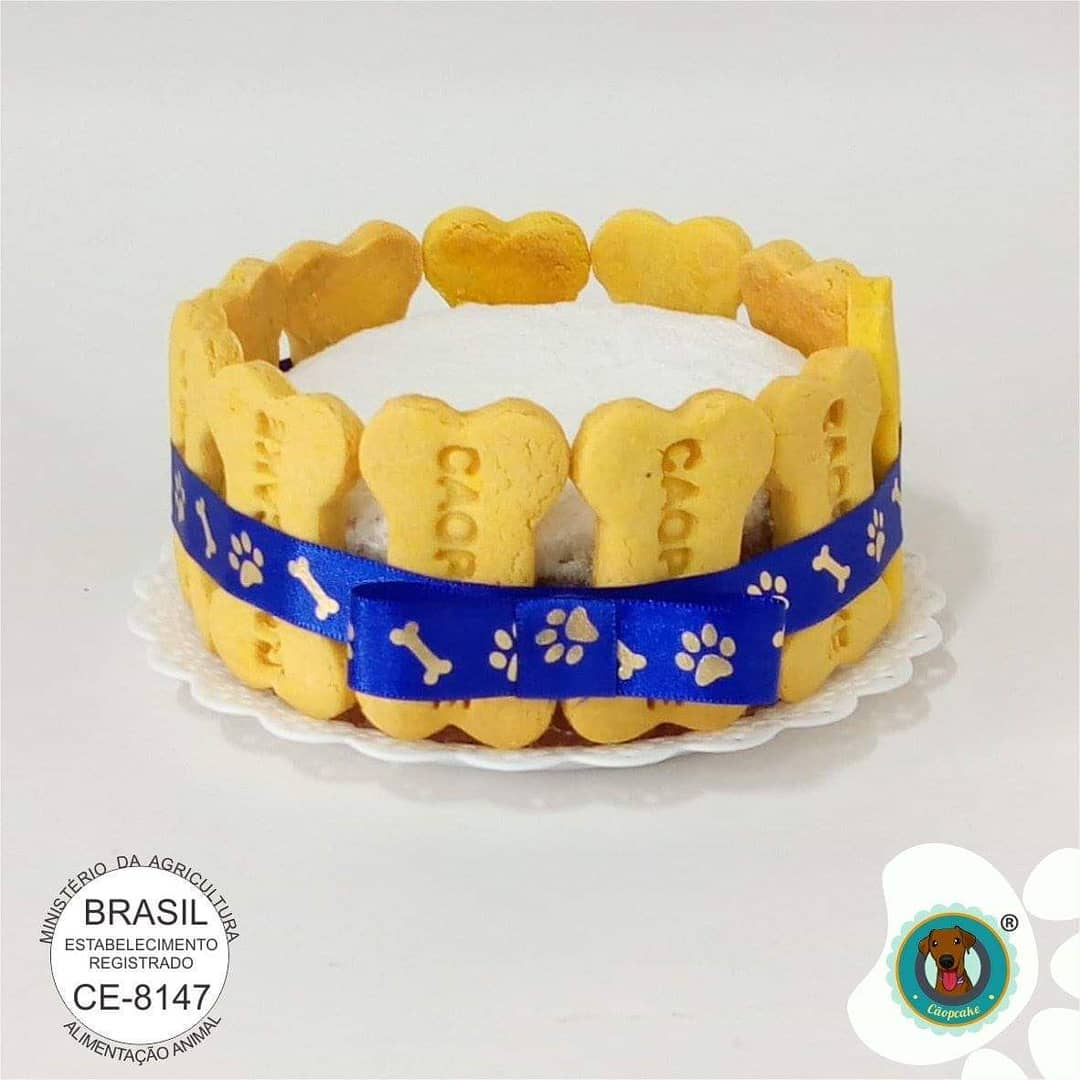

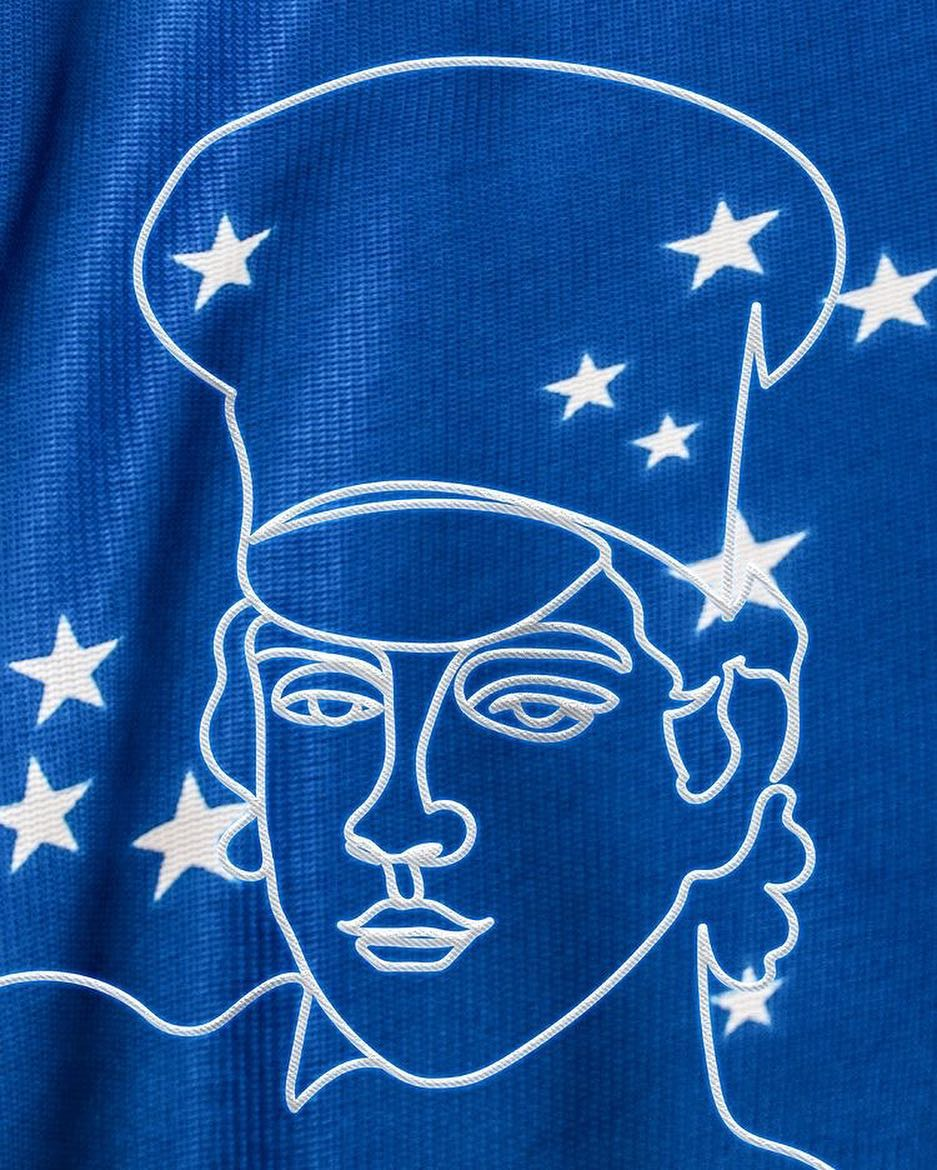

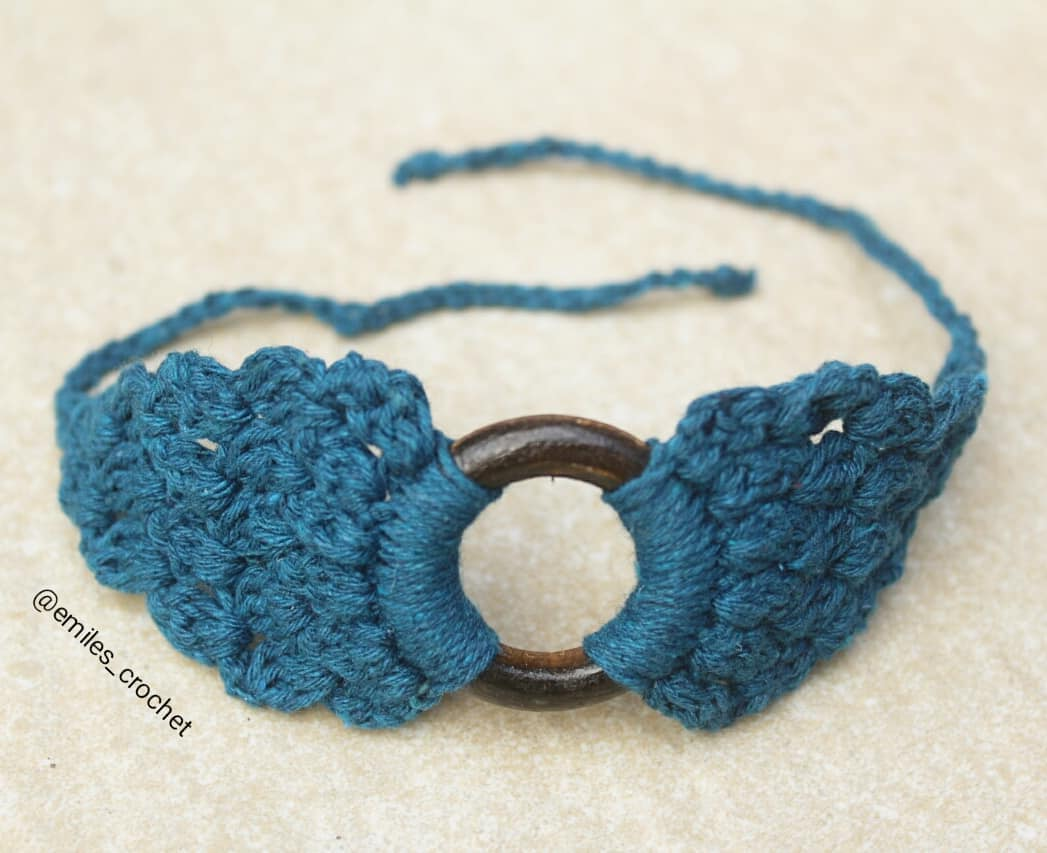

In [26]:
text = "Um laço azul"

image_paths = find_image(text, dataset, image_features, n=3)
show_images(image_paths)

# UNSPLASH

In [27]:
from sentence_transformers import SentenceTransformer, util
import glob
import torch
import pickle
import zipfile
import os
import zipfile
import json
import os
from tqdm.autonotebook import tqdm

img_folder = 'unsplash/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

In [ ]:
dataset = CustomDataSet("unsplash", transform=val_preprocess)


loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    drop_last=False)


In [ ]:
image_features = precompute_image_features(loader)

In [ ]:
def find_image(text_query, datatset, image_features, n=1):
    zeroshot_weights = text_encoder(text_query)
    zeroshot_weights = zeroshot_weights / np.linalg.norm(zeroshot_weights)
    distances = np.dot(image_features, zeroshot_weights.reshape(-1, 1))
    file_paths = []
    for i in range(1, n+1):
        idx = np.argsort(distances, axis=0)[-i, 0]
        file_paths.append('unsplash/' + dataset.get_image_name(idx))
    return file_paths

def show_images(image_list):
    for im_path in image_list:
        display(Image(filename=im_path))

In [ ]:
text = "un cane nero"

image_paths = find_image(text, dataset, image_features, n=3)
show_images(image_paths)

In [ ]:
%history -g -f anyfilename
